In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns

In [166]:
import plotly.express as px
from joblib import dump, load

In [6]:
# We Are going to do lots of training testing and splitting Lasso Regressions Lets Create a function 
# to make this easier
def train(X, y, alpha):
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)
    
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train, y_train)
    y_pred = lasso.predict(x_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    names = list(X.columns)
    lasso_coef = lasso.coef_
    coef_dict = dict(zip(names, lasso_coef))
    
    return mse, coef_dict

In [7]:
def elastic_results(X, y, alpha, L1):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)
    
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=L1)
    elastic_net.fit(x_train, y_train)
    y_pred = elastic_net.predict(x_test)
    
    mse = mean_absolute_error(y_test, y_pred)
    
    names = list(X.columns)
    coef = elastic_net.coef_
    coef_dict = dict(zip(names, coef))
    return mse, coef_dict

In [8]:
df1 = pd.read_csv("data/cleaned_df.csv", index_col=["UnitID"])

In [9]:
revenues_distribution = df1.iloc[:,1:7] #Revenues distribution (percentages of total revenues to each area)
revenues_dollar_amount = df1.iloc[:,7:13]
expenses_distribution = df1.iloc[:,13:21] #Expenses as a distribution
expenses_dollar_amount = df1.iloc[:, 21:28]

expenses_dollar_amount.head(3)

,Instruction_Expenses_As_Dollar_Amount,Research_Expenses_As_Dollar_Amount,Public_Service_Expenses_As_Dollar_Amount,Academic_Support_Expenses_As_Dollar_Amount,Student_Service_Expenses_As_Dollar_Amount,Institutional_Support_Expenses_As_Dollar_Amount,Other_Core_Expenses_As_Dollar_Amount
UnitID,,,,,,,
180203.0,2115359.76,218830.32,510604.08,218830.32,583547.52,1167095.04,2625963.84
138558.0,21084472.08,0.00,1506033.72,7530168.60,4518101.16,9538213.56,6526146.12
126182.0,18934322.61,0.00,1071754.11,2500759.59,6430524.66,5358770.55,1786256.85


## Staff diversity and Enrollment Diversity as principle components

In [10]:
staff_total = df1.iloc[:,29:58]  
staff_diversity_distribution = df1.iloc[:, 58:87]
enrollment_diversity = df1.iloc[:,87:100]

enrollment_diversity.head()

,Percent of full-time first-time undergraduates awarded any financial aid (SFA1819),Percent of full-time first-time undergraduates awarded federal state local or institutional grant aid (SFA1819),Percent of total enrollment that are American Indian or Alaska Native (DRVEF2013_RV),Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander (DRVEF2013_RV),Percent of total enrollment that are Asian (DRVEF2013_RV),Percent of total enrollment that are Native Hawaiian or Other Pacific Islander (DRVEF2013_RV),Percent of total enrollment that are Black or African American (DRVEF2013_RV),Percent of total enrollment that are Hispanic/Latino (DRVEF2013_RV),Percent of total enrollment that are White (DRVEF2013_RV),Percent of total enrollment that are Race/ethnicity unknown (DRVEF2013_RV),Percent of total enrollment that are Nonresident Alien (DRVEF2013_RV),Percent of total enrollment that are two or more races (DRVEF2013_RV),Percent of total enrollment that are women (DRVEF2013_RV)
UnitID,,,,,,,,,,,,,
180203.0,85.0,82.0,88.0,0.0,0.0,0.0,0.0,1.0,10.0,0.0,0.0,0.0,57.0
138558.0,91.0,86.0,0.0,1.0,1.0,0.0,12.0,6.0,78.0,0.0,2.0,1.0,54.0
126182.0,98.0,92.0,1.0,2.0,1.0,0.0,7.0,26.0,56.0,5.0,0.0,3.0,56.0
100654.0,90.0,87.0,0.0,1.0,1.0,0.0,92.0,1.0,5.0,1.0,0.0,0.0,55.0
100724.0,95.0,89.0,0.0,0.0,0.0,0.0,91.0,1.0,3.0,1.0,2.0,1.0,61.0


# Age as principle component

In [11]:
age_df = df1.iloc[:, 100:107]
age_distribution = df1.iloc[:, 107:113]

# ACT/SAT Scores a principle component

In [12]:
test_scores = df1.iloc[:,115:118]
test_scores.head()

,SAT Critical Reading 75th percentile score (IC2012_RV),SAT Math 75th percentile score (IC2012_RV),ACT Composite 75th percentile score (IC2012_RV)
UnitID,,,
180203.0,608.0,548.0,25.4
138558.0,420.0,410.0,17.0
126182.0,530.0,550.0,23.0
100654.0,455.0,460.0,19.0
100724.0,460.0,480.0,19.0


# Pre Processing and Modeling (Total Graduation Rates)

In [13]:
black_grad_rates_df = df1.loc[:,:].dropna(subset=[df1.columns[-1]])

x1 = df1.loc[:,:].drop([df1.columns[-1], df1.columns[-2]], axis=1)
y1 = df1[df1.columns[-2]]
x2 = black_grad_rates_df.drop(df1.columns[-2:], axis=1)
y2 = black_grad_rates_df.loc[:,df1.columns[-2]]

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.25, random_state=39)

In [15]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", Lasso(alpha=0.1))   
])

In [16]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', Lasso(alpha=0.1))])

In [17]:
y_pred = pipeline.predict(x_test)

In [18]:
mean_squared_error(y_test, y_pred)

443.4374267894562

In [19]:
#visualizing a few of the coeficients


In [20]:
#_ = plt.plot(range(stop-start), lasso_coef[start:stop])
#_ = plt.xticks(range(stop-start), names[start:stop], rotation=90)
#_ = plt.ylabel("Coeficients")
#plt.show()

In an Initial Model top 5 Negative Coefficients Were:

<ol>
    <li>Government_Grants</li>
    <li>Student_Service_Expense</li>
    <li>Parent/Child indicator</li>
    <li>Percent of total enrollment that are Black or African American</li>
    <li>Grand Total Undergraduate Age 25 and over</li>
</ol>
Top 5 Positive Coefficients
<ol>
    <li>Grand Total Undergraduate Age Under 25</li>
    <li>Research_Expenses</li>
    <li>SAT Math</li>
    <li>ACT Composite</li>
    <li>Total Women Uner 25</li>
</ol>
       

## Feature Engineering #1 Adding Principle Components (Total Grad Rate)

In [21]:
# First scale x2 using standard scaler
def add_PC(df):
    
    standard_scaler = StandardScaler()
    x1_scaled = standard_scaler.fit_transform(df)

    pca_transform = PCA(n_components=1)

    scaled_df = pd.DataFrame(x1_scaled, columns=df.columns)

    scaled_df["Revenues_Dist_PC"] = pca_transform.fit_transform(scaled_df[revenues_distribution.columns])

    scaled_df["Revenues_Dollar_Amount_PC"] = pca_transform.fit_transform(scaled_df[revenues_dollar_amount.columns])

    scaled_df["Expenses_Dollar_Amount_PC"] = pca_transform.fit_transform(scaled_df[expenses_dollar_amount.columns])

    scaled_df["Expenses_Dist_PC"] = pca_transform.fit_transform(scaled_df[expenses_distribution.columns])

    scaled_df["Staff_Total_PC"] = pca_transform.fit_transform(scaled_df[staff_total.columns])

    scaled_df["Staff_Dist_PC"] = pca_transform.fit_transform(scaled_df[staff_diversity_distribution.columns])

    scaled_df["Age_Total_PC"] = pca_transform.fit_transform(scaled_df[age_df.columns])

    scaled_df["Age_Dist_PC"] = pca_transform.fit_transform(scaled_df[age_distribution.columns])

    scaled_df["Enrollment_Diversity_PC"] = pca_transform.fit_transform(scaled_df[enrollment_diversity.columns])

    scaled_df["Test_Scores_PC"] = pca_transform.fit_transform(scaled_df[test_scores.columns])
    return(scaled_df)
x1_df = add_PC(x1)

# modeling with new Principle Components

In [22]:
train(x1_df, y1, 0.1)

(222.21488327841558,
 {'Core_Revenues': -0.0,
  'Tuition_And_Fees': 0.0,
  'Government_Grants': -2.458491287595699,
  'Private_Gifts': 0.0,
  'Investment_Return': 0.0,
  'Sales_And_Services': 0.7109671336499643,
  'Other_Revenues': 0.06221282490950318,
  'Tuition_And_Fees_As_Dollar_Amount': -0.0,
  'Government_Grants_As_Dollar_Amount': -0.0,
  'Private_Gifts_As_Dollar_Amount': 0.0,
  'Investment_Return_As_Dollar_Amount': -0.07681795288519744,
  'Sales_And_Services_As_Dollar_Amount': -0.0,
  'Other_Revenues_As_Dollar_Amount': -0.14633484091436494,
  'Core_Expenses': -0.0,
  'Instruction_Expenses': 0.2776124614889326,
  'Research_Expenses': 1.0903026197511378,
  'Public_Service_Expenses': -0.7387758191777416,
  'Academic_Support_Expenses': -0.0,
  'Student_Service_Expenses': -1.0516782329356458,
  'Institutional_Support_Expenses': -0.0,
  'Other_Core_Expenses': 0.0,
  'Instruction_Expenses_As_Dollar_Amount': 0.0,
  'Research_Expenses_As_Dollar_Amount': -0.0,
  'Public_Service_Expenses_As

### Adding more important features

There are some good opportunities for feature engineering expecially after exploring the data.

<ol>
    <li>Schools that have graduation rates of 100 % or 0 % are clear outliers. This may be because these schools have very small cohort sizes</li>
    <li>Certain states have a graduation rate much higher than other states. So creating an ordinal variable called state rank may help make better predictions</li>
    <li> Binning some of my continuous variables also highlighted trends in my EDA. I will bin some of my Principle components and some of my continuous variables to create ordinal variables
</ol>

In [23]:
df2 = pd.read_csv("data/feature_engineer.csv", index_col="UnitID")

In [24]:
class_size = "Incoming_Class_Grand_Total"

# view size of schools to look for outliers

(0.0, 20000.0)

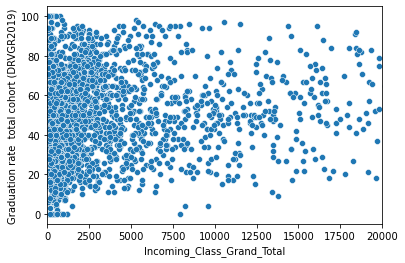

In [25]:
sns.scatterplot(data=df1, x=class_size, y=df1.columns[-2])
plt.xlim([0,20000])

#### many schools small schools with 0 and 100% graduation rates

In [26]:
var = "Rev"
for i in x1_df.columns:
    if var in i:
        print(i)

Core_Revenues
Other_Revenues
Other_Revenues_As_Dollar_Amount
Revenues_Dist_PC
Revenues_Dollar_Amount_PC


## Lets create Categorical ranking variables (Total Graduation Rate)

In [27]:
def cat_rank(df, category, agg_func, target):
    group = df.groupby(by=category)
    group_agg = group.agg([agg_func])[df.columns[target]]
    group_rank = group_agg.sort_values(agg_func)\
        .reset_index().reset_index()\
        .loc[:,[category, "index"]].set_index(category)
    group_rank.columns = ["rank"]
    group_rank["rank"] = group_rank["rank"].apply(lambda x: x + 1)
    group_rank_map = dict(zip(group_rank.index.to_numpy(),group_rank["rank"].to_numpy()))
    return group_rank_map

state_map = cat_rank(df2, "State", "mean", -2)
carnegie_basic_map = cat_rank(df2, "Carnegie_Classification_Basic", "mean", -2)
sector_map = cat_rank(df2, "Sector", "mean", -2)
carnegie_size_map = cat_rank(df2, "Carnegie_Classification_Size_Setting", "mean", -2)

In [28]:
cat_ranks_df = pd.concat([df2["State"].replace(state_map),
 df2["Carnegie_Classification_Size_Setting"].replace(carnegie_size_map),
 df2["Sector"].replace(sector_map),
 df2["Carnegie_Classification_Basic"].replace(carnegie_basic_map)], axis=1)

In [29]:
df1.reset_index(inplace=True)

In [30]:
cat_ranks_df.reset_index(inplace=True)

In [31]:
df1 = cat_ranks_df.merge(df1, on="UnitID", how="outer")

In [32]:
df1.set_index("UnitID", inplace=True)

## Remove Outliers

In [33]:
lower_bound = df1[df1.columns[-2]].quantile(0.001)

In [34]:
upper_bound = df1[df1.columns[-2]].quantile(0.999)

In [35]:
upper_bound

100.0

In [36]:
filt1 = df1[df1.columns[-2]] != 100
filt2 = df1[df1.columns[-2]] != 0

In [37]:
df1 = df1[filt1 & filt2] # these graduation rates are just not feasible for a regular sized institution

In [38]:
df1.head(2)

,State,Carnegie_Classification_Size_Setting,Sector,Carnegie_Classification_Basic,Core_Revenues,Tuition_And_Fees,Government_Grants,Private_Gifts,Investment_Return,Sales_And_Services,...,State abbreviation (HD2018)_Vermont,State abbreviation (HD2018)_Virgin Islands,State abbreviation (HD2018)_Virginia,State abbreviation (HD2018)_Washington,State abbreviation (HD2018)_West Virginia,State abbreviation (HD2018)_Wisconsin,State abbreviation (HD2018)_Wyoming,State abbreviation (HD2018)_isMissing,Graduation rate total cohort (DRVGR2019),Graduation rate Black non-Hispanic (DRVGR2019)
UnitID,,,,,,,,,,,,,,,,,,,,,
180203,12,14,1,3,7078959.0,2.0,60.0,7.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,NaN
222178,15,19,5,19,136379482.0,57.0,4.0,17.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,53.0


# Now Lets Try Again with New Features

Also we will see that because we have so many features that are collinear an elastic net will have slightly better performance

In [39]:
x3 = df1.drop(df1.columns[-2:], axis=1)
y3 = df1[df1.columns[-2]]

In [40]:
mae, coefficients = elastic_results(x3, y3, 0.1, 0.5)

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128726.2542573049, tolerance: 77.37586349557522
  model = cd_fast.enet_coordinate_descent(


In [41]:
mae

9.52385588649032

# Feature Selection and Model Optimization

In [44]:
x4 = df1.drop(df1.columns[-2:], axis=1)
y4 = df1[df1.columns[-2]]

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x4, y4, test_size = 0.2, random_state=1)

In [104]:
params = {
    "alpha": np.linspace(0.05, 0.25, 5),
    "l1_ratio": np.linspace(0,1,11)
}

In [111]:
elastic_net = ElasticNet()
clf = RandomizedSearchCV(elastic_net, params, random_state=42)

In [112]:
clf.fit(x_train, y_train)

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105990.98652066395, tolerance: 61.83100165975103
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107141.1356991462, tolerance: 61.73817482710928
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108417.75191873248, tolerance: 62.35603125864454
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/pyth

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107848.64883023225, tolerance: 61.73817482710928
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109244.69425975977, tolerance: 62.35603125864454
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108095.7905663077, tolerance: 63.014179958534896
  model = cd_fast.enet_coordinate_descent(
/Users/robertcampbell/opt/anaconda3/lib/pyt

RandomizedSearchCV(estimator=ElasticNet(),
                   param_distributions={'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25]),
                                        'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42)

In [113]:
y_pred = clf.predict(x_test)

In [114]:
mean_absolute_error(y_pred, y_test)

9.159021211361877

In [51]:
y_pred[10:15]

array([30.8130501 , 93.0748401 , 47.02232588, 42.91322439, 50.4919191 ])

In [52]:
y_test[10:15]

UnitID
236188    24.0
164988    88.0
130989    58.0
481410    25.0
366553    24.0
Name: Graduation rate  total cohort (DRVGR2019), dtype: float64

# We can try to improve accuracy with XG Boost

In [221]:
tree_params = {
    "clf__booster": ['gbtree'],
    "clf__n_estimators": np.arange(50,250,5),
    "clf__max_depth": np.arange(1,12,1),
    "clf__subsample": np.arange(0,1,0.05),
    "clf__colsample_bytree": np.arange(0,1,0.05)
    
    
}

In [119]:
params={"objective": "reg:squarederror", "max_depth": 4}

In [120]:
matrix = xgb.DMatrix(x4,y4)

In [121]:
cv_results = xgb.cv(dtrain=matrix, params=params, nfold=5, 
                    as_pandas=True, seed=123, 
                    num_boost_round=50, metrics="mae")

In [122]:
cv_results["test-mae-mean"].tail(1)

49    8.862576
Name: test-mae-mean, dtype: float64

In [94]:
reg_params = {
    "objective": "reg:squarederror",
    "booster": "gblinear",
    "alpha": 0.001, #L1 Regularization Parameter
    "lambda": 0.001, #L2 Regularization Parameter
    
}

In [131]:
cv_results = xgb.cv(dtrain=matrix, params=reg_params, nfold=5, 
                    as_pandas=True, seed=12, 
                    num_boost_round=50, metrics="mae")

In [132]:
cv_results["test-mae-mean"].tail(1)

49    9.896423
Name: test-mae-mean, dtype: float64

In [79]:
lambda_list = [0.001, 0.01, 0.1, 1, 10]
results = []
for i in lambda_list:
    reg_params["alpha"] = i
    cv_results = xgb.cv(dtrain=matrix, params=reg_params, nfold=5, 
                    as_pandas=True, seed=123, 
                    num_boost_round=20, metrics="mae")
    
    results.append((i, cv_results["test-mae-mean"].tail(1)))
results

[(0.001,
  19    10.52388
  Name: test-mae-mean, dtype: float64),
 (0.01,
  19    10.58098
  Name: test-mae-mean, dtype: float64),
 (0.1,
  19    10.813402
  Name: test-mae-mean, dtype: float64),
 (1,
  19    11.041414
  Name: test-mae-mean, dtype: float64),
 (10,
  19    11.492177
  Name: test-mae-mean, dtype: float64)]

# Elastic Net Will be our model of choice

XB boosting has slightly more accurate predictions; however the elastic net is much more easy to interperate. 

In [167]:
e_net = clf.best_estimator_

In [184]:
dump(e_net, 'data/GradRatesModel.joblib') 

['data/GradRatesModel.joblib']

In [174]:
e_net.coef_

array([ 2.31208512e-01,  7.95373915e-01,  1.01919316e+00,  2.84971475e-01,
        1.91204585e-08,  7.07323368e-02, -1.22867389e-01,  1.00261714e-01,
        8.44189123e-02,  1.88489630e+00,  1.24986875e-01, -1.70516179e-08,
        1.06784316e-08, -9.81830895e-09, -1.53213301e-08, -8.05039041e-08,
       -9.72108854e-09, -9.48401285e-09,  9.12843379e-02,  3.80426420e-01,
       -3.96069386e-02,  7.25313644e-03, -1.48532726e-01, -1.63313559e-02,
        1.01056924e-01, -6.81619821e-09, -2.65612707e-08,  6.48543014e-09,
       -8.97078815e-09,  5.30278388e-08, -1.19938751e-08,  2.71605712e-09,
        5.59699119e-03,  4.54617115e-03, -1.28791616e-02,  0.00000000e+00,
        4.63430523e-01, -3.44074571e-01, -4.05335958e-02, -2.60652690e-02,
        6.32086769e-02,  0.00000000e+00, -1.36718412e-01,  1.58723518e-01,
       -1.61252601e-02, -1.10182092e-02,  0.00000000e+00, -2.75539396e-02,
       -4.42826778e-01,  0.00000000e+00,  1.53743518e-02,  1.29585518e-02,
       -3.71856610e-02,  

In [178]:
coefs_dict = dict(zip(x3.columns, e_net.coef_)) 

In [181]:
sorted_coef = sorted(coefs_dict.items(), key=lambda item: item[1])

In [185]:
dump(sorted_coef, 'data/GradRatesCoefs.joblib')

['data/GradRatesCoefs.joblib']